In [1]:
#
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib as mpl
from mne.stats import permutation_cluster_test
from mne.stats import permutation_cluster_1samp_test
from functools import partial
from mne.stats import ttest_1samp_no_p, permutation_t_test,fdr_correction,spatio_temporal_cluster_1samp_test
from IPython.display import clear_output
from itertools import permutations,combinations
#sns.set(style="darkgrid")
sns.set(font_scale=1.5)
from scipy import stats

data_path = os.path.dirname(os.getcwd())

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']


trial_len = 2
remove_first = 0.5 #seconds

save_path = data_path + '/data/coherence'

info = mne.io.read_raw_fif((save_path+'-info'),preload=True)
clear_output()

In [10]:
# data coherence from fieldtrip
raw_fname = data_path + '/entrainment_python/coh_fieldtrip_1.5hzsmooth_0.5-15.mat'
raw_fname = data_path + '/entrainment_python/coh_fieldtrip_2hzsmooth_0.5-15.mat'
raw_fname = data_path + '/entrainment_python/coh_fieldtrip_1.5hzsmoothDPSS_0.5-5.mat'
raw_fname = data_path + '/entrainment_python/coh_fieldtrip_freqdeptsmoothDPSS_0.5-15.mat'

mat = scipy.io.loadmat(raw_fname)

#speech = mat['behaviour']['speech'][0][0]
envelop = mat['envelop']
lip = mat['lip']
freqs = mat['freq'][0]
freqs = np.arange(0.5,15.5,0.5)

delay = np.arange(-5,5.5,0.5) / 10
con = 'All'
frames=[]
for s in range(0,len(subject_name)):
    for d in range(0,len(delay)):        
        for fr in range(0,len(freqs)):
            df = pd.DataFrame({'Condition':con,'Freq':freqs[fr],'Delay':delay[d],'Subject':subject_name[s],
                               'Feature':'envelop','Data':[envelop[s,:,fr,d]]})
            frames.append(df) 

            df = pd.DataFrame({'Condition':con,'Freq':freqs[fr],'Delay':delay[d],'Subject':subject_name[s],
                               'Feature':'lipaparature','Data':[lip[s,:,fr,d]]})
            frames.append(df) 
    print(str(d)+'-'+subject_name[s])
clear_output()    
data=pd.concat((frames),axis=0)
a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)

a = data.reset_index()

df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
data = pd.concat([a,df], axis=1)

data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)


In [11]:
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

condition = ['hyper','normal','hypo','All']
condition = ['All']

In [12]:
# functions

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    if 'mask' in data:
        mask = data['mask'].any()
        mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask,cmap='RdBu_r')
    else:
        mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax)


def plot_topo_image(df,vmin,vmax,typeF,cmap):
    fg = sns.FacetGrid(df,col=typeF,margin_titles=True)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b.fig.subplots_adjust(top=0.7)
    b.fig.subplots_adjust(right=0.8)
    cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='Coherence')

    
def plot_topo_image2(df,vmin,vmax,typeF):
    fg = sns.FacetGrid(df,col=typeF,margin_titles=True)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b.fig.subplots_adjust(top=0.7)
    b.fig.subplots_adjust(right=0.8)
    cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='Coherence')
    
def get_subject_avg_inDelay(data,delay,features,freq,condition,subject_name):
    frames = []
    value = []
    for d in delay:
        A = []
        for s in subject_name:
            B = []
            for fr in freq:
                a = data.loc[features,fr,condition,d,s]['Data'].get_values()
                B.append(a[0])
            B = np.asarray(B)
            B = np.mean(B,axis=0)            
            A.append(B)
            
        A = np.asarray(A)
        A = np.mean(A,axis=0)
        df = pd.DataFrame({'Data':[A],'Delay':d})
        frames.append(df)
        value.append(min(A))
        value.append(max(A))

    df=pd.concat((frames),axis=0)
    return df,value

def get_subject_avg_inFreq(data,delay,features,freq,condition,subject_name):
    frames = []
    value = []
    for fr in freq:
        B = []
        for s in subject_name:
            a = data.loc[features,fr,condition,delay,s]['Data'].get_values()
            B.append(a[0])
            
        B = np.asarray(B)
        B = np.mean(B,axis=0)  
        df = pd.DataFrame({'Data':[B],'Freq':fr})
        frames.append(df)
        value.append(min(B))
        value.append(max(B))

    df=pd.concat((frames),axis=0)
    return df,value

def plot_delay_avg(data,delay,features,freq,condition,subject_name):
    a = data.loc[features,freq,condition,delay,subject_name]['Coherence']
    a = a.reset_index()

    g = sns.FacetGrid(a, col="Freq", row="Condition",margin_titles=True,height=8,aspect=2)
    b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", 
                        value="Coherence",color="deep")
    b = b.set_xlabels('Delay')
    b = b.set_ylabels('Coherence')
    
def plot_delay_avg_BestChannel(data,delay,features,freq,condition,subject_name,ch):
    a = data.loc[features,freq,condition,delay,subject_name][ch]
    a = a.reset_index()

    g = sns.FacetGrid(a, col="Freq", row="Condition",margin_titles=True,size=6,aspect=2)
    b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", 
                        value=ch,color="deep").add_legend()
    b = b.set_xlabels('Delay')
    b = b.set_ylabels('Coherence - ' + ch)
    
def plot_freq_avg(data,delay,features,fi,freq,condition,subject_name):
    a = data.loc[features,fi,condition,delay,subject_name]['Coherence']
    a = pd.DataFrame(a.reset_index())

    g = sns.FacetGrid(a,  col='Delay',size=6,aspect=2)
    b = g.map_dataframe(sns.tsplot, time="Freq", unit="Subject",condition="Feature", value="Coherence",
                    color="deep", err_style="ci_bars")
    b = b.set_xlabels('Frequency (Hz)')
    b = b.set_ylabels('Coherence')
    b.set(xticks=fi,xlim=(2, 17))
    b.set_xticklabels(freq,rotation=0)
    b.fig.legend(loc=1)
    b.set_titles('EEG Delayed by ' +str(delay[0])+' s')
    
    
def get_P_value_Coherence(data,features,freq_band,condition,delay,subject_name):
    A = []    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[features[0],fr,c,d,subject_name]['Coherence']
                group2 = data.loc[features[1],fr,c,d,subject_name]['Coherence']
                p = run_permutation_test2(group1.get_values(),group2.get_values(),1000)
                a = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'p-value':[p]})
                A.append(a)
                
    P = pd.concat((A),axis=0)
    return P 



def get_P_value_coherence_parallel_ch(data,features,freq_band,condition,delay,subject_name,numSamples,channels):
    A = []
    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[features[0],fr,c,d,subject_name][channels].get_values()
                group2 = data.loc[features[1],fr,c,d,subject_name][channels].get_values()
                group1 = np.asarray(group1)
                group2 = np.asarray(group2)
                AA = np.dstack((group1.T,group2.T))

                a = Parallel(n_jobs=7)(delayed(processInput)(i) for i in AA)
                for ch in range(0,len(channels)):
                    p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'FeatureTest':[features],
                                      'channel':channels[ch],'p-value':a[ch]})
                    A.append(p)
                
    P = pd.concat((A),axis=0)
    return P   

def run_permutation_test2(x,y,numSamples):
    #keeping the subject association
    pooled = np.vstack([x,y]).T
    d0 = abs(x.mean() - y.mean())
    d = np.zeros((numSamples,))
    for k in range(numSamples):
        for i in range(len(x)):
            a = pooled[i]
            np.random.shuffle(a)
            pooled[i] = a
            
        starZ = pooled[:,0]
        starY = pooled[:,1]    
        d[k] = abs(starZ.mean() - starY.mean())

    p = len(np.where( d > d0 )[0])
    p = p / float(numSamples)

    return p  

def processInput(i):
    a = run_permutation_test2(i[:,0],i[:,1],1000)
    return a

def get_P_value_coherence_ch_surrogate(data,dataS,features,freq_band,condition,delay,subject_name,numSamples,channels):
    A = []
    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[features,fr,c,d,subject_name][channels].get_values()
                group2 = dataS.loc[features,fr,c,d,subject_name][channels].get_values()
                group1 = np.asarray(group1)
                group2 = np.asarray(group2)
                AA = np.dstack((group1.T,group2.T))

                a = Parallel(n_jobs=7)(delayed(processInput_1tailed)(i) for i in AA)
                for ch in range(0,len(channels)):
                    p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'FeatureTest':[features],
                                      'channel':channels[ch],'p-value':a[ch]})
                    A.append(p)
                
    P = pd.concat((A),axis=0)
    return P 

def get_P_value_coherence_parallel_ch_surrogate(data,dataS,features,freq_band,condition,delay,subject_name,numSamples,channels):
    A = []
    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[features,fr,c,d,subject_name][channels].get_values()
                group2 = dataS.loc[features,fr,c,d,subject_name][channels].get_values()
                group1 = np.asarray(group1)
                group2 = np.asarray(group2)
                AA = np.dstack((group1.T,group2.T))

                a = Parallel(n_jobs=7)(delayed(processInput_1tailed)(i) for i in AA)
                for ch in range(0,len(channels)):
                    p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'FeatureTest':[features],
                                      'channel':channels[ch],'p-value':a[ch]})
                    A.append(p)
                
    P = pd.concat((A),axis=0)
    return P   


def run_permutation_test1_tailed(x,y,numSamples):
    #keeping the subject association
    pooled = np.vstack([x,y]).T
    d0 = (x.mean() - y.mean())
    d = np.zeros((numSamples,))
    for k in range(numSamples):
        for i in range(len(x)):
            a = pooled[i]
            np.random.shuffle(a)
            pooled[i] = a
            
        starZ = pooled[:,0]
        starY = pooled[:,1]    
        d[k] = (starZ.mean() - starY.mean())

    p = len(np.where( d > d0 )[0])
    p = p / float(numSamples)

    return p


def processInput_1tailed(i):
    a = run_permutation_test1_tailed(i[:,0],i[:,1],1000)
    return a


def get_P_value_coherence_parallel_ch_surrogate_nonParametric(data,dataS,features,freq_band,condition,delay,
                                                              subject_name,channels):
    A = []
    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[features,fr,c,d,subject_name][channels].get_values()
                group2 = dataS.loc[features,fr,c,d,subject_name][channels].get_values()
                group1 = np.asarray(group1)
                group2 = np.asarray(group2)
                AA = np.dstack((group1.T,group2.T))

                a = Parallel(n_jobs=7)(delayed(processInput__nonParametric_Ttest)(i) for i in AA)
                for ch in range(0,len(channels)):
                    p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'FeatureTest':[features],
                                      'channel':channels[ch],'p-value':a[ch]})
                    A.append(p)
                
    P = pd.concat((A),axis=0)
    return P   


def processInput__nonParametric_Ttest(i):
    a = run_nonParametric_Ttest(i[:,0],i[:,1])
    return a


def plot_delayTimeCoursePartial(data,features,Removedfeatures,delay,freq_band,subject_name):    
    a = data.loc[features,delay,Removedfeatures,delay,freq_band,condition,subject_name]['partialCoh']
    a = pd.DataFrame(a.reset_index())
    g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6,aspect=2)
    b = g.map_dataframe(sns.tsplot, time="FeatureDelay", unit="Subject",condition="Feature", value='partialCoh',color="deep").add_legend()
    b = b.set_xlabels('Delay')
    b = b.set_ylabels('Partial Coherence')
    
def get_P_value_Partial(data,features,freq_band,condition,delay,subject_name):
    A = []    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[features[0],d,features[1],d,fr,c,subject_name]['partialCoh']
                group2 = data.loc[features[1],d,features[0],d,fr,c,subject_name]['partialCoh']
                p = run_permutation_test2(group1.get_values(),group2.get_values(),1000)
                a = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'p-value':[p]})
                A.append(a)
                
    P = pd.concat((A),axis=0)
    return P 



def get_data_for_clusterpermutation(data1,data2,f1,f2,freq_band,condition,delay,subject_name):
    frame1 =[]
    frame2 =[]
    for d in delay:
        condition1 = []
        condition2 = []
        for s in subject_name:
            A = data1.loc[f1,freq_band,condition,d,s]['Data'].get_values()
            B = data2.loc[f2,freq_band,condition,d,s]['Data'].get_values()
            condition1.append(A[0])
            condition2.append(B[0])

        condition2 = np.asarray(condition2)
        condition1 = np.asarray(condition1)

        frame1.append(condition1)
        frame2.append(condition2)

    condition2 = np.asarray(frame2)
    condition1 = np.asarray(frame1)

    condition1 = np.swapaxes(condition1,0,1)
    condition2 = np.swapaxes(condition2,0,1)
    
    return condition1,condition2



# fig 1b

In [ ]:
# look at behaviour

# fig 1C

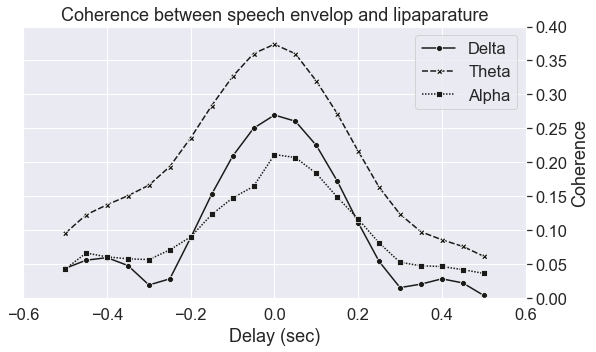

In [5]:
# coherence beteewn stimuli in delay
save_path = data_path + '/data/coherence/Coh-removedFirst-0.5-2_envelop-'+ \
                    'EMA_trial_normalized_coh-multitaper3cycle-1-40.5Hz-0.5step.pkl'

data=pd.read_pickle(save_path)

a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

freq =  [ '1 - 4 Hz','4 - 8 Hz','8 - 12 Hz']
freq_band = [2.5,6,10]

features = ['lipaparature']

delay = np.arange(-5,6) / 10
delay = np.arange(-5,5.5,0.5) / 10

condition = ['All']
#condition = ['normal']

a = data.loc[features,freq_band,condition,delay,'aa']['Coherence']
a = a.reset_index()


f, ax = plt.subplots(figsize=(9,5))
freq =  [ 'Delta','Theta','Alpha']

sns.lineplot(x="Delay", y="Coherence",style="Freq", markers=True,color='k',data=a)
plt.xlabel('Delay (sec)')
plt.ylabel('Coherence')
plt.legend(freq,loc=1)
plt.title('Coherence between speech envelop and ' +features[0])
plt.xlim([-0.6,0.6])

ax.yaxis.tick_right()

ax.yaxis.set_label_position("right")

plt.ylim([0,0.4])

plt.savefig('fig1c.eps', format='eps', dpi=300)

# Figure 2a


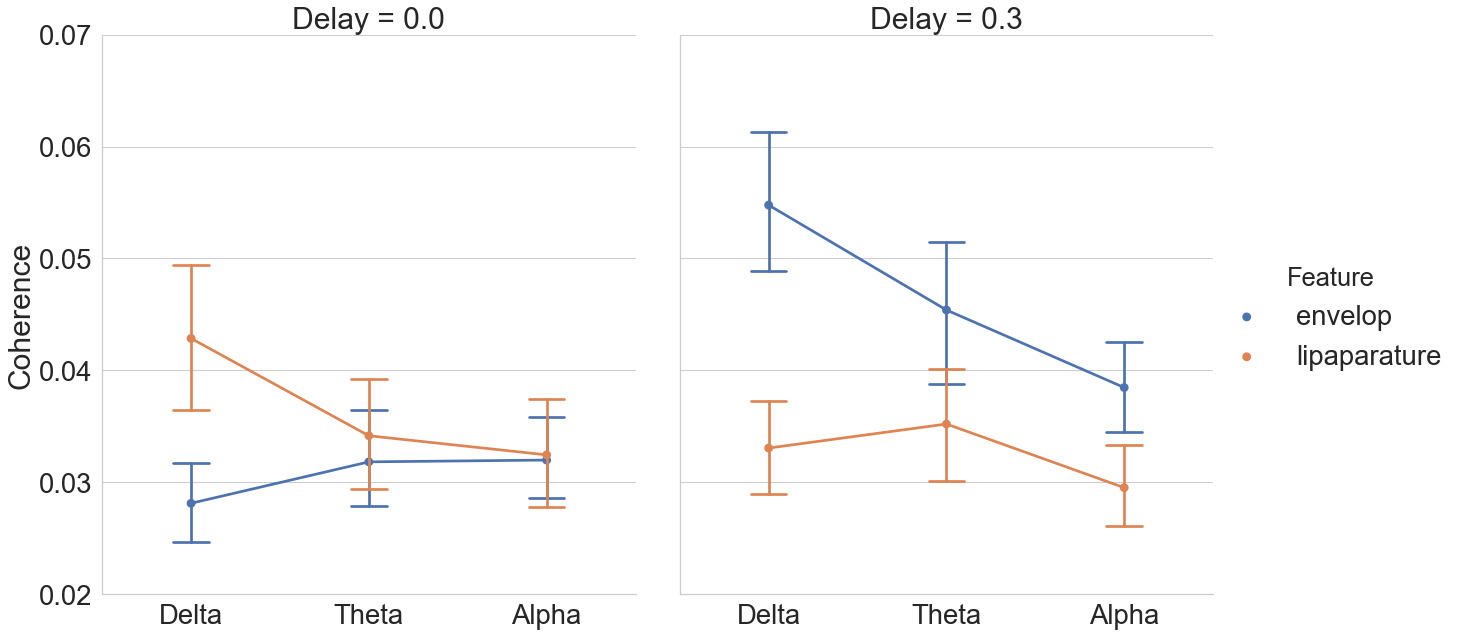

In [16]:
# Figure 2a
features = ['envelop','lipaparature']



fi = [2.5]
delay = [0,0.3]
freq = [ ' 1 - 4Hz']
freq = [ 'Delta']

fi = [2.5,6,10]
delay = [0,0.3]
freq = [ ' 1 - 4Hz',
 ' 4 - 8Hz',
 ' 8 - 12Hz']
freq = [ 'Delta',
 'Theta',
 'Alpha']

a = data.loc[features,fi,condition,delay,subject_name]['Coherence']
a = pd.DataFrame(a.reset_index())

#f, AX = plt.subplots(figsize=(15,6))

#ax = sns.barplot(x="Freq", y="Coherence", hue="Feature", data=a,capsize=.2)
#ax.set_xticklabels(freq,rotation=0)
#ax.set_title('Delay '+ str(int(delay[0]*1000)) +' ms')
sns.set(font_scale=2.5)
sns.set_style("whitegrid")

g = sns.catplot(x="Freq", y="Coherence", hue="Feature", data=a, col="Delay", kind="point", 
                height=10, aspect=0.9,
                capsize=.2)
g.set_xticklabels(freq)
#(g.despine(left=True))  
#g.set_titles('')
g.set_xlabels('')
g.set(ylim=(0.02, 0.07))
#g.set_xticklabels('')
#plt.legend(loc=1, prop={'size': 15})
plt.savefig('fig2a.eps', transparent=True, format='eps', dpi=300)


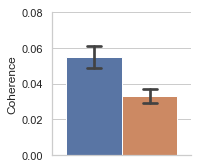

In [14]:
#
features = ['envelop','lipaparature']



fi = [2.5]
delay = [0.3]
freq = [ ' 1 - 4Hz']
freq = [ 'Delta']


a = data.loc[features,fi,condition,delay,subject_name]['Coherence']
a = pd.DataFrame(a.reset_index())

sns.set(font_scale=1)
sns.set_style("whitegrid")

g = sns.catplot(x="Freq", y="Coherence", hue="Feature", data=a, col="Delay", 
                kind="bar", height=3, aspect=1,legend =False,
                capsize=.1)
g.set_xticklabels(freq,rotation=0)
#g.despine(left=True)
g.set(ylim=(0, 0.08))

g.set_titles('')
g.set_titles('')
g.set_xlabels('')
g.set_xticklabels('')
g.set_ylabels('Coherence')

plt.savefig('fig3CC_'+str(delay[0])+'.eps', transparent=True, format='eps', dpi=300)



# fig 2b

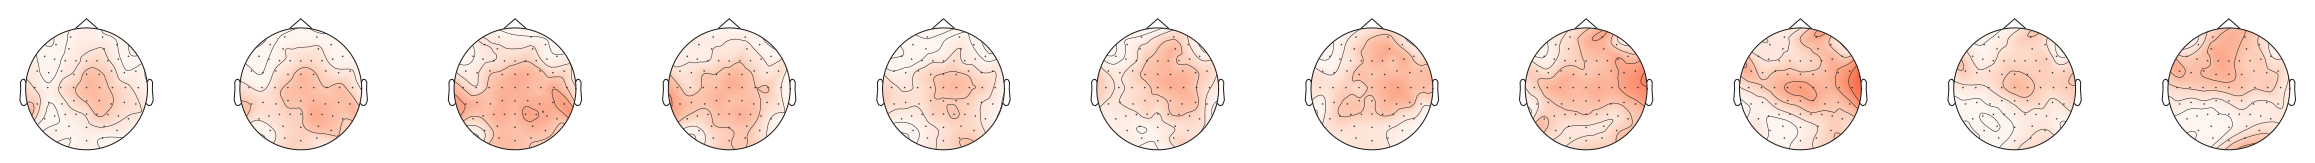

In [86]:
# get mask from filedtrip
sns.set(font_scale=1.5)

freq_band = [2.5]

features = ['envelop']
features = ['lipaparature']



if (features[0]=='envelop'):
    vmin = 0.03
    vmax = 0.07
else:
    vmin = 0.03
    vmax = 0.06

delay = np.arange(-5,5.5,0.5) / 10

def get_data_for_clusterpermutation(data1,data2,f1,f2,freq_band,condition,delay,subject_name):
    frame1 =[]
    frame2 =[]
    for d in delay:
        A = data1.loc[f1,freq_band,condition,d,subject_name]['Data'].get_values()
        B = data2.loc[f2,freq_band,condition,d,subject_name]['Data'].get_values()
        condition2 = np.stack(B)
        condition1 = np.stack(A)

        frame1.append(condition1)
        frame2.append(condition2)


    condition1 = np.swapaxes(frame1,0,1)
    condition2 = np.swapaxes(frame2,0,1)
    
    return condition1,condition2

def plot_topo_image3(df,vmin,vmax,typeF,cmap):
    fg = sns.FacetGrid(df,col=typeF)
    b = fg.map_dataframe(draw_heatmap2, 'Data')
    b = b.set_xlabels('')
    b = b.set_titles('')
    
def draw_heatmap2(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mask = data['mask'].any()
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask,
                        mask_params = dict(marker='o', markerfacecolor='k', markeredgecolor='k',
     linewidth=0, markersize=5))


condition1,condition2=get_data_for_clusterpermutation(data,data,features[0],features[0],
                                                      freq_band,condition,delay,subject_name)

A=np.mean(condition1,axis=0)


#
if((freq_band[0]>2.5) & (features[0]=='lipaparature')):
    mask = np.array(np.zeros((59, len(delay))), dtype=bool)
else:
    raw_fname = data_path + '/entrainment_python/'+str(freq_band[0])+features[0]+'_mask.mat'
    mat = scipy.io.loadmat(raw_fname)
    mask = mat['mask']
    mask = np.array(mask, dtype=bool)
    
    
frame = []
for d in range(0,len(delay)):
    df = pd.DataFrame({'mask':[mask[:,d]],'Data':[A[d,:]],'Delay':delay[d]})
    frame.append(df)
df = pd.concat((frame),axis=0)

delay = np.arange(-5,6) / 10
aa = df.loc[df['Delay'].isin(delay)]
A = np.vstack(aa['Data'].get_values())
plot_topo_image3(aa,vmin,vmax,'Delay','Reds')  

plt.savefig('fig2b_'+str(freq_band[0])+features[0]+'.eps', transparent=True, 
            format='eps', dpi=300)


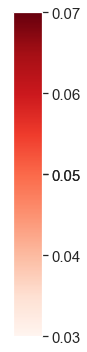

In [88]:
# colorbar
vmin=0.03
vmax=0.07


# plot colorbar
a = np.array([[0,1]])
plt.figure(figsize=(5,1.5))
img = plt.imshow(a, cmap="Reds")
plt.gca().set_visible(False)
cax = plt.axes([0.82,0.25,0.08,3])
#plt.colorbar(orientation="vertical", cax=cax)
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
sm.set_array([])
cax = plt.colorbar(sm,ticks=np.round(np.linspace(vmin,vmax,6),decimals=2),cax=cax,
             orientation="vertical")
plt.tick_params(labelsize=15) 


# figure 3A


In [5]:
# get mask from filedtrip
freq_band = [2.5]
#freq_band = np.arange(1,4,0.5)

features = ['envelop','lipaparature']
delay = np.arange(-5,5.5,0.5) / 10

condition1,condition2=get_data_for_clusterpermutation(data,data,features[0],features[1],
                                                      freq_band,condition,delay,subject_name)

A=np.mean(condition1-condition2,axis=0)




#
raw_fname = data_path + '/entrainment_python/2.5_lip_envelop_mask.mat'

mat = scipy.io.loadmat(raw_fname)

mask = mat['mask']
mask = np.array(mask, dtype=bool)



frame = []
for d in range(0,len(delay)):
    df = pd.DataFrame({'mask':[mask[:,d]],'Data':[A[d,:]],'Delay':delay[d]})
    frame.append(df)
df = pd.concat((frame),axis=0)

#vmin = np.round(min(A.flatten()),decimals=2)
#vmax = np.round(max(A.flatten()),decimals=2)
#plot_topo_image(df,vmin,vmax,'Delay','Reds')





In [ ]:
#
delay = [0.3]


aa = df[df['Delay'].isin(delay)]
x = aa['Data'].get_values()[0]
mask  = aa['mask'].get_values()[0]


vmin = np.round(x.min(),decimals=4)
vmax = np.round(x.max(),decimals=4) 

vmin=-0.035
vmax=-vmin


f, AX = plt.subplots(figsize=(18,6))


mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask,cmap = 'RdBu_r',
                        mask_params = dict(marker='o', markerfacecolor='k', markeredgecolor='k',
     linewidth=0, markersize=6))

plt.savefig('fig3a_'+str(delay[0])+'.eps', transparent=True, format='eps', dpi=300)


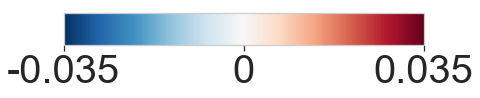

In [44]:
# colorbar
vmin=-0.04
vmax=-vmin


# plot colorbar
a = np.array([[0,1]])
plt.figure(figsize=(5,1.5))
img = plt.imshow(a, cmap="RdBu_r")
plt.gca().set_visible(False)
#cax = plt.axes([0.82,0.25,0.05,3])
cax = plt.axes([0.25,0.82,1,0.3])
#plt.colorbar(orientation="vertical", cax=cax)
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
sm.set_array([])
cax = plt.colorbar(sm,ticks=np.round(np.linspace(vmin,vmax,3),decimals=2),cax=cax,
             orientation="horizontal")
plt.tick_params(labelsize=40) 

vmin = -0.035
vmax=-vmin

cax.ax.set_xticklabels([vmin, '0', vmax])  # vertically oriented colorbar

plt.savefig('fig3aColorbar.png', transparent=True,format='png', dpi=300)


# figure3B

C:\Users\EspVicon\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


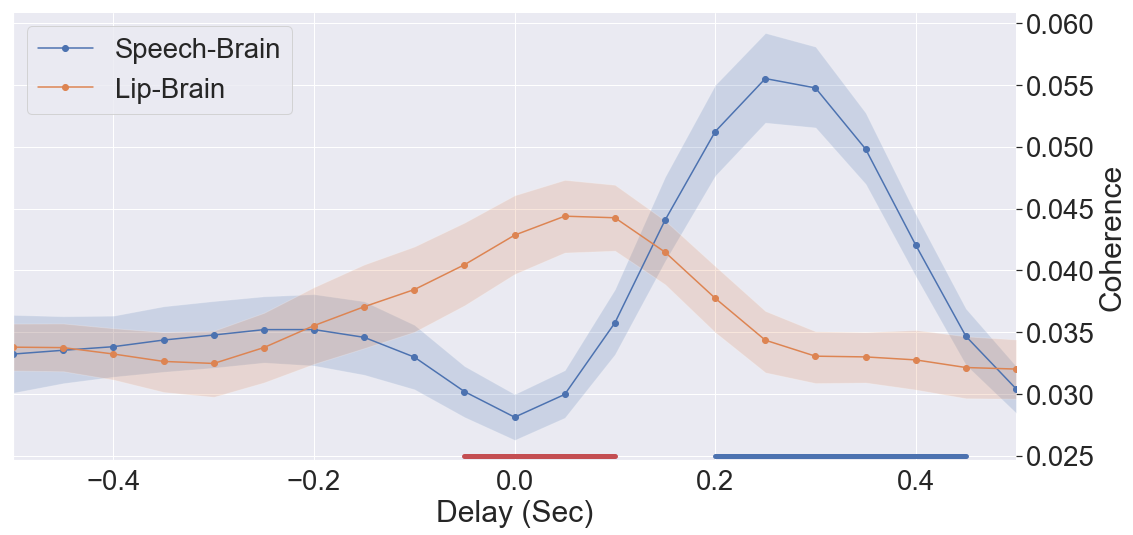

In [12]:
# figure3B
def plot_delay_avg(data,delay,features,freq,condition,subject_name):    
   # a = data.loc[features,freq,condition,delay,subject_name][['FC5','C5','CP5','T7']].get_values()
   # aa = np.mean(a,axis=1)
   # data['Coherence'] =  pd.Series(aa, index=data.index)
    
    a = data.loc[features,freq,condition,delay,subject_name]['Coherence']

    a = a.reset_index()

    g = sns.FacetGrid(a, col="Freq", row="Condition",margin_titles=False,height=8,aspect=2)
    b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature",
                        value="Coherence",color="deep",marker='o')
    #b = g.map_dataframe(sns.lineplot, x="Delay",hue="Feature", y="Coherence",color="deep",marker='o')
    b = b.set_xlabels('Delay (Sec)')
    
    b.ax.yaxis.tick_right()
    b.ax.yaxis.set_label_position("right")
    b.set_ylabels('Coherence')
    
sns.set(font_scale=2.5)
sns.set_style("darkgrid")
#sns.set_style("white")


delay = np.arange(-5,5.5,0.5) / 10
freq = [2.5]
features = ['envelop','lipaparature']

#f, AX = plt.subplots(figsize=(15,8))


#plot_delay_avg(data,delay,features,freq,condition,subject_name)
#plot_delay_avg(data_reg_surrogate,delay,features,freq,condition,subject_name)
plot_delay_avg(data,delay,features,freq,condition,subject_name)

#plt.legend(['Speech-Brain','Lip-Brain'],loc=2)
#plt.title('Freq = 1 - 4 Hz')
#plt.ylim([0.024, 0.07])
plt.title('')
plt.xlabel('Delay (Sec)')

plt.axhline(y=0.025, xmin=0.45, xmax=0.6, linewidth=5, color = 'r')
plt.axhline(y=0.025, xmin=0.7, xmax=0.95, linewidth=5, color = 'b')
#plt.legend(['Speech-Brain','Lip-Brain','Lip > Speech','Speech > Lip'],loc=2)
plt.legend(['Speech-Brain','Lip-Brain'],loc=2)
plt.savefig('fig3b.eps', transparent=True, format='eps', dpi=300)


# figure 3C

In [3]:
# partial coherence
save_path = data_path + '/data/partialCoh/PartialCoh-removedFirst-0.5-2-multitaper3cycle-1-40.5Hz-0.5step.pkl'

data=pd.read_pickle(save_path)
a  = data['Data'].apply(lambda x: np.mean(x))
data['partialCoh'] = pd.Series(a, index=data.index)
a = data.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
data = pd.concat([a,df], axis=1)
data.set_index(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay',
                        'Freq','Condition','Subject'], inplace=True)
data.sort_index(inplace=True)



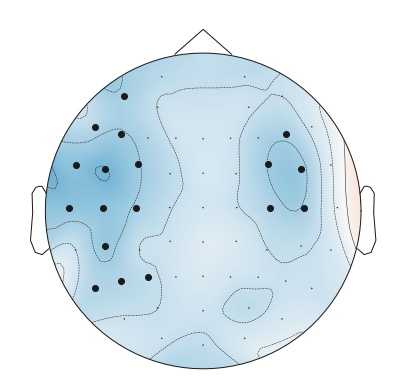

In [5]:
# get mask from filedtrip

def get_data_for_clusterpermutation(data1,data2,f1,f2,freq_band,condition,delay,subject_name):
    frame1 =[]
    frame2 =[]
    for d in delay:
        condition1 = []
        condition2 = []
        for s in subject_name:
            A = data1.loc[f1,d,f2,d,freq_band,condition,s]['Data'].get_values()
            B = data2.loc[f2,d,f1,d,freq_band,condition,s]['Data'].get_values()
            condition1.append(A[0])
            condition2.append(B[0])

        condition2 = np.asarray(condition2)
        condition1 = np.asarray(condition1)

        frame1.append(condition1)
        frame2.append(condition2)

    condition2 = np.asarray(frame2)
    condition1 = np.asarray(frame1)

    condition1 = np.swapaxes(condition1,0,1)
    condition2 = np.swapaxes(condition2,0,1)
    
    return condition1,condition2



freq_band = [2.5]
features = ['envelop','lipaparature']
delay = np.arange(-5,5.5,0.5) / 10
delay = [0]

condition1,condition2=get_data_for_clusterpermutation(data,data,features[0],features[1],
                                                      freq_band,condition,delay,subject_name)

A=np.mean(condition1-condition2,axis=0)


#
raw_fname = data_path + '/entrainment_python/2.5_'+str(delay[0])+'delay_pcoh_lip_envelop_mask.mat'

mat = scipy.io.loadmat(raw_fname)

mask = mat['mask']
mask = np.array(mask, dtype=bool)


frame = []
for d in range(0,len(delay)):
    df = pd.DataFrame({'mask':[mask[:,d]],'Data':[A[d,:]],'Delay':delay[d]})
    frame.append(df)
df = pd.concat((frame),axis=0)

vmin = np.round(min(A.flatten()),decimals=4)
vmax = np.round(max(A.flatten()),decimals=4)

vmin=-0.0035
vmax=-vmin


aa = df[df['Delay'].isin(delay)]
x = aa['Data'].get_values()[0]


f, AX = plt.subplots(figsize=(18,6))


mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask,cmap = 'RdBu_r',
                        mask_params = dict(marker='o', markerfacecolor='k', markeredgecolor='k',
     linewidth=0, markersize=6))

plt.savefig('fig3C_'+str(delay[0])+'.eps', transparent=True, format='eps', dpi=300)


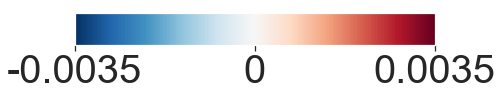

In [30]:
# colorbar
vmin=-0.0035
vmax=-vmin


# plot colorbar
a = np.array([[0,1]])
plt.figure(figsize=(5,1.5))
img = plt.imshow(a, cmap="RdBu_r")
plt.gca().set_visible(False)
#cax = plt.axes([0.82,0.25,0.05,3])
cax = plt.axes([0.25,0.82,1,0.3])
#plt.colorbar(orientation="vertical", cax=cax)
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
sm.set_array([])
cax = plt.colorbar(sm,ticks=np.round(np.linspace(vmin,vmax,3),decimals=4),cax=cax,
             orientation="horizontal")
plt.tick_params(labelsize=40) 

cax.ax.set_xticklabels([vmin, '0', vmax])  # vertically oriented colorbar

plt.savefig('fig3CColorbar.eps', transparent=True, format='eps', dpi=300)


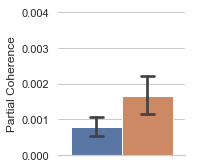

In [53]:
#
features = ['envelop','lipaparature']


freq_band = [2.5]
delay = [0]
freq = [ ' 1 - 4Hz']
freq = [ 'Delta']

a = data.loc[features,delay,features,delay,freq_band,condition,subject_name]['partialCoh']
a = pd.DataFrame(a.reset_index())


sns.set(font_scale=1)
sns.set_style("whitegrid")

g = sns.catplot(x="Freq", y="partialCoh", hue="Feature", data=a, col="FeatureDelay", 
                kind="bar", height=3, aspect=1,legend =False,
                capsize=.1)
g.set_xticklabels(freq,rotation=0)
g.despine(left=True)
g.set(ylim=(0, 0.004))

g.set_titles('')
g.set_titles('')
g.set_xlabels('')
g.set_xticklabels('')
g.set_ylabels('Partial Coherence')

plt.savefig('fig3CP_'+str(delay[0])+'.eps', transparent=True, format='eps', dpi=300)
